# Load data and import

In [0]:
import json
import pandas as pd
 
# Parse 'items' whether it's a JSON array or a JSON-encoded string of that array
def parse_items(cell: str):
    if pd.isna(cell) or cell.strip() in ("", "[]"):
        return []
    s = cell.strip()
    try:
        # Case 1: already a JSON array
        if s.startswith("[") and s.endswith("]"):
            return json.loads(s)
        # Case 2: JSON string containing the array -> decode twice
        return json.loads(json.loads(s))
    except Exception:
        # Fallback: strip outer quotes and unescape, then parse
        if s.startswith('"') and s.endswith('"'):
            s = s[1:-1].replace('\\"', '"')
        return json.loads(s)
 
GoogleAnalytics = pd.read_csv(
    "/Volumes/workspace/default/capstone/clean_google_analytics.csv",
    converters={"items": parse_items},
    # Helps if the CSV used backslash escapes for quotes inside the field
    escapechar="\\"
)
 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10000)

# Google anaytics
#GoogleAnalytics = pd.read_csv("google_analytics.csv")
# orders
orders = pd.read_csv("/Volumes/workspace/default/capstone/clean_orders.csv")
# sales 
sales = pd.read_csv("/Volumes/workspace/default/capstone/clean_sales.csv")
# material
material = pd.read_csv("/Volumes/workspace/default/capstone/clean_material.csv")
# customer
customer = pd.read_csv("/Volumes/workspace/default/capstone/clean_customer.csv")
# custoff_times
cutoff_times = pd.read_csv("/Volumes/workspace/default/capstone/clean_cutoff_times.csv")
# operating hours
operating_hours = pd.read_csv("/Volumes/workspace/default/capstone/clean_operating_hours.csv")

In [0]:
chunks = pd.read_csv(
    "/Volumes/workspace/default/capstone/clean_visit_plan.csv",
    chunksize=500_000,  # 500k rows at a time
)

visit_plan = pd.concat(chunks, ignore_index=True)

In [0]:
chunks = pd.read_csv(
    "/Volumes/workspace/default/capstone/clean_GA (1).csv",
    chunksize=500_000,  # 500k rows at a time
)

googles = pd.concat(chunks, ignore_index=True)
googles.head()

,customer_id,event_name,device_category,device_mobile_brand_name,device_operating_system,event_page_name,event_page_title,items,event_date,event_ts_utc,abandoned,purchase_segment,False_by_purchase,recovered
0,500245685,page_view,Desktop,Google,Windows,Mycoke Dashboard,Home,[],2024-06-13,2024-06-13 04:43:59.908000+00:00,False,500245685.5,no purchase,not applicable
1,500245685,page_view,Desktop,Google,Windows,Mycoke Dashboard,Home,[],2024-06-13,2024-06-13 04:43:59.908000+00:00,False,500245685.5,no purchase,not applicable
2,500245685,nav_link_click,Desktop,Google,Windows,Mycoke Dashboard,Home,[],2024-06-13,2024-06-13 04:44:27.635000+00:00,False,500245685.5,no purchase,not applicable
3,500245685,page_view,Desktop,Google,Windows,Mycoke Invoices,Invoice-list,[],2024-06-13,2024-06-13 04:44:27.635000+00:00,False,500245685.5,no purchase,not applicable
4,500245685,page_view,Desktop,Google,Windows,Mycoke Invoices,Invoice-list,[],2024-06-13,2024-06-13 04:44:27.635000+00:00,False,500245685.5,no purchase,not applicable


In [0]:
googles.dtypes

customer_id                   int64
event_name                   object
device_category              object
device_mobile_brand_name     object
device_operating_system      object
event_page_name              object
event_page_title             object
items                        object
event_date                   object
event_ts_utc                 object
abandoned                    object
purchase_segment            float64
False_by_purchase            object
recovered                    object
dtype: object

# Build the table

In [0]:
visit_plan.head(n=5)

,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc
0,500405850,G133,"Glenwood Springs, CO",14,sl,48hrs,customer,4:00:00 PM,2,2020-07-20,2020-07-20T22:00:00.000Z,2021-12-13,2021-12-14T05:49:54.551Z
1,500286563,G236,"Denver, CO",7,of,48hrs,customer,4:00:00 PM,2,2019-11-04,2019-11-04T23:00:00.000Z,2021-12-13,2021-12-14T05:49:54.551Z
2,600057832,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,2,2021-08-02,2021-08-02T21:30:00.000Z,2021-12-13,2021-12-14T05:49:54.551Z
3,500431853,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,2,2020-04-06,2020-04-06T21:30:00.000Z,2021-12-13,2021-12-14T05:49:54.551Z
4,600076074,G142,"Pocatello, ID",7,ez,24hrs,customer,2:00:00 PM,6,2019-06-07,2019-06-07T20:00:00.000Z,2021-12-13,2021-12-14T05:49:54.551Z


In [0]:
visit_plan = visit_plan.sort_values(by=['customer_id', 'snapshot_ts_utc'], ascending=[True, True])
visit_plan.head(n=5)

,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc
9924056,500245685,G111,"Draper, UT",7,of,48hrs,customer,3:30:00 PM,4,2020-04-08,2020-04-08T21:30:00.000Z,2021-11-11,2021-11-12T05:53:33.777Z
12556156,500245685,G111,"Draper, UT",7,of,48hrs,customer,3:30:00 PM,2,2020-04-06,2020-04-06T21:30:00.000Z,2021-11-11,2021-11-12T05:53:33.777Z
2417594,500245685,G111,"Draper, UT",7,of,48hrs,customer,3:30:00 PM,2,2020-04-06,2020-04-06T21:30:00.000Z,2021-11-12,2021-11-13T05:43:57.752Z
14637425,500245685,G111,"Draper, UT",7,of,48hrs,customer,3:30:00 PM,4,2020-04-08,2020-04-08T21:30:00.000Z,2021-11-12,2021-11-13T05:43:57.752Z
12680497,500245685,G111,"Draper, UT",7,of,48hrs,customer,3:30:00 PM,4,2020-04-08,2020-04-08T21:30:00.000Z,2021-11-13,2021-11-13T16:03:10.456Z


In [0]:
visit_plan['frequency'].value_counts()

7     12632783
14     2640715
28     1492296
21       84409
70       34237
56        8253
42        2872
35        2865
Name: frequency, dtype: int64

In [0]:
# ✅ 1. Define the valid recurring frequency values
valid_frequencies = [
    7,
    14,
    21,
    28,
    35,
    42,
    56,
    70,
]

# ✅ 2. Filter to only rows that contain these valid frequencies
visit_plan_filtered = visit_plan[visit_plan['frequency'].isin(valid_frequencies)].copy()

# ✅ 3. Convert SNAPSHOT_DATE to datetime if it's not already
visit_plan_filtered['snapshot_ts_utc'] = pd.to_datetime(visit_plan_filtered['snapshot_ts_utc'], errors='coerce')

# ✅ 4. Sort by CUSTOMER_ID, then most recent SNAPSHOT_DATE
visit_plan_filtered = visit_plan_filtered.sort_values(['customer_id', 'snapshot_ts_utc'], ascending=[True, False])

# ✅ 5. Keep only the *most recent valid row* per CUSTOMER_ID
visit_plan_latest = visit_plan_filtered.drop_duplicates(subset='customer_id', keep='first')

# ✅ 6. Final output
visit_plan_latest.reset_index(drop=True, inplace=True)

visit_plan_latest.head(n=5)


,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc
0,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,2,2024-11-18,2024-11-18T22:30:00.000Z,2025-08-22,2025-08-22 17:36:02.938000+00:00
1,500245689,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,6,2022-09-30,2022-09-30T21:30:00.000Z,2025-08-22,2025-08-22 17:36:02.938000+00:00
2,500245690,G111,"Draper, UT",14,sl,48hrs,customer,3:30:00 PM,2,2024-11-25,2024-11-25T22:30:00.000Z,2025-08-22,2025-08-22 17:36:02.938000+00:00
3,500245724,G111,"Draper, UT",28,sl,48hrs,customer,3:30:00 PM,2,2024-11-18,2024-11-18T22:30:00.000Z,2025-08-22,2025-08-22 17:36:02.938000+00:00
4,500245736,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,5,2024-11-21,2024-11-21T22:30:00.000Z,2025-08-22,2025-08-22 17:36:02.938000+00:00


In [0]:
# Make sure ANCHOR_DATE is a datetime type
visit_plan_latest['anchor_ts_utc'] = pd.to_datetime(visit_plan_latest['anchor_ts_utc'], errors='coerce')

# Add a column with the day of the week (e.g. Monday, Tuesday)
visit_plan_latest['anchor_day_of_week'] = visit_plan_latest['anchor_ts_utc'].dt.day_name()

# Preview
visit_plan_latest.head()


/home/spark-d634c90a-61a6-4565-af04-9d/.ipykernel/2764/command-4543664493940965-1700185979:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visit_plan_latest['anchor_ts_utc'] = pd.to_datetime(visit_plan_latest['anchor_ts_utc'], errors='coerce')
/home/spark-d634c90a-61a6-4565-af04-9d/.ipykernel/2764/command-4543664493940965-1700185979:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visit_plan_latest['anchor_day_of_week'] = visit_plan_latest['anchor_ts_utc'].dt.day_name()


,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc
0,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00
1,500245689,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Friday,2022-09-30,2022-09-30 21:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00
2,500245690,G111,"Draper, UT",14,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-25,2024-11-25 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00
3,500245724,G111,"Draper, UT",28,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00
4,500245736,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Thursday,2024-11-21,2024-11-21 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00


In [0]:
GoogleAnalytics = GoogleAnalytics.sort_values(by=['event_ts_utc'], ascending=[False])
GoogleAnalytics.head(n=10)

,customer_id,event_name,device_category,device_mobile_brand_name,device_operating_system,event_page_name,event_page_title,items,event_date,event_ts_utc
2760173,501774205,update_cart,Desktop,Google,Windows,Mycoke Orders - Cart,Cart,[],2025-05-25,2025-05-26T03:59:44.194Z
2760172,501774205,update_cart,Desktop,Google,Windows,Mycoke Orders - Cart,Cart,[],2025-05-25,2025-05-26T03:59:33.564Z
2760171,501774205,remove_from_cart,Desktop,Google,Windows,Mycoke Orders - Cart,Cart,"[{'item_id': '122366', 'quantity': '1'}]",2025-05-25,2025-05-26T03:59:27.124Z
2760170,501774205,remove_from_cart,Desktop,Google,Windows,Mycoke Orders - Cart,Cart,"[{'item_id': '121750', 'quantity': '1'}]",2025-05-25,2025-05-26T03:58:56.269Z
2760169,501774205,update_cart,Desktop,Google,Windows,Mycoke Orders - Cart,Cart,[],2025-05-25,2025-05-26T03:58:47.464Z
2760167,501774205,page_view,Desktop,Google,Windows,Mycoke Orders - Cart,Cart,[],2025-05-25,2025-05-26T03:58:39.450Z
2760168,501774205,page_view,Desktop,Google,Windows,Mycoke Orders - Product:,Category: All Products,[],2025-05-25,2025-05-26T03:58:39.450Z
2760164,501774205,view_item_list,Desktop,Google,Windows,Mycoke Orders - Product:,Category: All Products,[],2025-05-25,2025-05-26T03:58:38.069Z
2760165,501774205,page_view,Desktop,Google,Windows,Mycoke Orders - Product:,Category,[],2025-05-25,2025-05-26T03:58:38.069Z
2760166,501774205,view_item_list,Desktop,Google,Windows,Mycoke Orders - Product:,Category: All Products,"[{'item_id': '133129', 'quantity': '1'}, {'ite...",2025-05-25,2025-05-26T03:58:38.069Z


In [0]:
#EVENT_TIMESTAMP

GoogleAnalytics['event_ts_utc'] = pd.to_datetime(GoogleAnalytics['event_ts_utc'])

Earliest Event date is 05/31/2024. 

latest event date is 05/25/2025

In [0]:
GoogleAnalytics[GoogleAnalytics['event_name'] == 'purchase'].count()

customer_id                 32506
event_name                  32506
device_category             32506
device_mobile_brand_name    32506
device_operating_system     32506
event_page_name             32506
event_page_title            32506
items                       32506
event_date                  32506
event_ts_utc                32506
dtype: int64

In [0]:
import pandas as pd
import numpy as np

# --- Input: visit_plan_latest with columns including ANCHOR_DAY_OF_WEEK & FREQUENCY ---
# Example:
# visit_plan_latest = pd.DataFrame({...})

# 1) Clean types
visit_plan_latest = visit_plan_latest.copy()
visit_plan_latest['snapshot_ts_utc'] = pd.to_datetime(visit_plan_latest['snapshot_ts_utc'], errors='coerce')
visit_plan_latest['anchor_ts_utc']   = pd.to_datetime(visit_plan_latest['anchor_ts_utc'],   errors='coerce')
visit_plan_latest['anchor_day_of_week'] = visit_plan_latest['anchor_day_of_week'].astype(str).str.strip()
visit_plan_latest['frequency'] = visit_plan_latest['frequency'].astype(str).str.strip()

# 2) Frequency → days mapping
freq_days = {
    '7': 7,
    '14': 14,
    '21': 21,
    '28': 28,
    '35': 35,
    '42': 42,
    '56': 56,
    '70': 70,
}
# keep only valid frequencies
vp = visit_plan_latest[visit_plan_latest['frequency'].isin(freq_days.keys())].copy()

# 3) Range bounds (inclusive start, exclusive end is fine)
# "2 weeks before the week of 05/27/2024" → start from Monday 2024-05-13
range_start = pd.Timestamp('2024-05-27') - pd.Timedelta(days=14)  # 2024-05-13 (Mon)
# "2 weeks after the week of 05/26/2025"  → through Monday 2025-06-09
range_end   = pd.Timestamp('2025-05-26') + pd.Timedelta(days=14)  # 2025-06-09 (Mon)

# 4) Helper: day name → weekday index (Mon=0..Sun=6)
wk_map = {d: i for i, d in enumerate(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])}
def weekday_index(day_name: str) -> int:
    # be forgiving with case/spaces
    dn = day_name.strip().title()
    return wk_map.get(dn, None)

# 5) Build expanded schedule
records = []
cols = vp.columns.tolist()  # to copy all original columns per expanded row

for _, row in vp.iterrows():
    # resolve weekday and period length in days
    wd = weekday_index(row['anchor_day_of_week'])
    if wd is None:
        continue  # skip if unrecognized day
    period_days = freq_days[row['frequency']]

    # find first cutoff_start on the correct weekday ON OR AFTER range_start
    offset = (wd - range_start.weekday()) % 7
    first_start = range_start + pd.Timedelta(days=offset)

    # generate repeating windows until range_end
    start = first_start
    while start < range_end:
        end = start + pd.Timedelta(days=period_days)
        rec = {c: row[c] for c in cols}
        rec['cutoff_start'] = start.normalize()
        rec['cutoff_end']   = end.normalize()
        records.append(rec)
        # next window starts where the previous ended
        start = end

expanded = pd.DataFrame.from_records(records)

# (Optional) Keep within the exact range if you want to clamp windows:
# expanded = expanded[(expanded['cutoff_end'] > range_start) & (expanded['cutoff_start'] < range_end)]

# Order nicely
expanded = expanded.sort_values(['customer_id', 'cutoff_start']).reset_index(drop=True)

# Show result
expanded.head(20)
print(f"Customers expanded: {expanded['customer_id'].nunique()} | Rows: {len(expanded)}")


Customers expanded: 6334 | Rows: 219649


In [0]:
expanded.head(10)

,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc,cutoff_start,cutoff_end
0,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-13,2024-05-20
1,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-20,2024-05-27
2,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-27,2024-06-03
3,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-03,2024-06-10
4,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-10,2024-06-17
5,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-17,2024-06-24
6,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-24,2024-07-01
7,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-01,2024-07-08
8,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-08,2024-07-15
9,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-15,2024-07-22


## Add Purchase Date

In [0]:
import pandas as pd

# --- Assumptions ---
# expanded : schedule table [CUSTOMER_ID, cutoff_start, cutoff_end, ...]
# GoogleAnalytics : GA events [CUSTOMER_ID, EVENT_TIMESTAMP, EVENT_NAME, ...]

# 1) Clean types — make ALL timestamps UTC tz-aware so comparisons work
expanded = expanded.copy()
expanded['cutoff_start'] = pd.to_datetime(expanded['cutoff_start'], utc=True, errors='coerce')
expanded['cutoff_end']   = pd.to_datetime(expanded['cutoff_end'],   utc=True, errors='coerce')

ga = GoogleAnalytics.copy()
ga['event_ts_utc'] = pd.to_datetime(ga['event_ts_utc'], utc=True, errors='coerce')

# 2) Keep purchases only (and only the columns we need)
ga_purch = ga.loc[ga['event_name'].eq('purchase'), ['customer_id', 'event_ts_utc']].copy()

# 3) Expand: left join on CUSTOMER_ID, then keep only purchases inside each window
exp_keyed = expanded.reset_index().rename(columns={'index': 'row_id'})
merged = exp_keyed.merge(ga_purch, on='customer_id', how='left')

# inside-window mask (inclusive)
mask = merged['event_ts_utc'].between(merged['cutoff_start'], merged['cutoff_end'], inclusive='both')

# Rows (row_id, purchase_date) for matches — one per purchase in the window
hits = (merged.loc[mask, ['row_id', 'event_ts_utc']]
              .rename(columns={'event_ts_utc': 'purchase_date'}))

# 4) Reattach to schedule. Left-merge duplicates schedule rows when multiple purchases exist.
# If no purchases for a row_id, you'll get exactly one row with purchase_date = NaT
expanded_with_all_purchases = (
    exp_keyed.merge(hits, on='row_id', how='left')
             .drop(columns='row_id')
)

# Optional: nice ordering
expanded_with_all_purchases = expanded_with_all_purchases.sort_values(
    by=['customer_id', 'cutoff_start', 'purchase_date'], kind='mergesort'
).reset_index(drop=True)

# Preview
expanded_with_all_purchases.head(10)


,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc,cutoff_start,cutoff_end,purchase_date
0,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-13 00:00:00+00:00,2024-05-20 00:00:00+00:00,NaT
1,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-20 00:00:00+00:00,2024-05-27 00:00:00+00:00,NaT
2,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-27 00:00:00+00:00,2024-06-03 00:00:00+00:00,NaT
3,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-03 00:00:00+00:00,2024-06-10 00:00:00+00:00,NaT
4,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-10 00:00:00+00:00,2024-06-17 00:00:00+00:00,NaT
5,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-17 00:00:00+00:00,2024-06-24 00:00:00+00:00,NaT
6,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-24 00:00:00+00:00,2024-07-01 00:00:00+00:00,NaT
7,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-01 00:00:00+00:00,2024-07-08 00:00:00+00:00,NaT
8,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-08 00:00:00+00:00,2024-07-15 00:00:00+00:00,NaT
9,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-15 00:00:00+00:00,2024-07-22 00:00:00+00:00,NaT


In [0]:
expanded_with_all_purchases.head(10)

,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc,cutoff_start,cutoff_end,purchase_date
0,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-13 00:00:00+00:00,2024-05-20 00:00:00+00:00,NaT
1,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-20 00:00:00+00:00,2024-05-27 00:00:00+00:00,NaT
2,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-27 00:00:00+00:00,2024-06-03 00:00:00+00:00,NaT
3,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-03 00:00:00+00:00,2024-06-10 00:00:00+00:00,NaT
4,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-10 00:00:00+00:00,2024-06-17 00:00:00+00:00,NaT
5,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-17 00:00:00+00:00,2024-06-24 00:00:00+00:00,NaT
6,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-24 00:00:00+00:00,2024-07-01 00:00:00+00:00,NaT
7,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-01 00:00:00+00:00,2024-07-08 00:00:00+00:00,NaT
8,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-08 00:00:00+00:00,2024-07-15 00:00:00+00:00,NaT
9,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-15 00:00:00+00:00,2024-07-22 00:00:00+00:00,NaT


In [0]:
expanded_with_all_purchases.shape

(226378, 16)

## Add Added to Cart

In [0]:
import pandas as pd

# df is your expanded schedule+purchases dataframe (no new rows to be added)
df = expanded_with_all_purchases.copy()

# GA events prepped
ga = GoogleAnalytics.copy()
ga['event_ts_utc'] = pd.to_datetime(ga['event_ts_utc'], utc=True, errors='coerce')

# Only add_to_cart events (keep only what we need)
ga_cart = ga.loc[ga['event_name'].eq('add_to_cart'), ['customer_id', 'event_ts_utc']].copy()

# Ensure schedule columns are tz-aware datetimes (safe if already)
for col in ['cutoff_start', 'cutoff_end', 'purchase_date']:
    df[col] = pd.to_datetime(df[col], utc=True, errors='coerce')

# Key rows so we can aggregate and merge the result back without duplicating rows
exp_keyed = df.reset_index().rename(columns={'index': 'row_id'})

# Join all candidate add_to_cart events by CUSTOMER_ID
merged = exp_keyed.merge(ga_cart, on='customer_id', how='left')

# Build masks per-row for the two cases
no_purchase  = merged['purchase_date'].isna()
has_purchase = ~no_purchase

mask_no_purchase = no_purchase & merged['event_ts_utc'].between(
    merged['cutoff_start'], merged['cutoff_end'], inclusive='both'
)

mask_has_purchase = (
    has_purchase
    & (merged['event_ts_utc'] >= merged['cutoff_start'])
    & (merged['event_ts_utc'] <  merged['purchase_date'])  # strictly before purchase
)

# Candidate add_to_cart timestamps that satisfy the appropriate window rules
merged['cand_added_to_cart'] = merged['event_ts_utc'].where(
    mask_no_purchase | mask_has_purchase
)

# For each original row, take the max qualifying add_to_cart timestamp
added_to_cart_by_row = (
    merged.groupby('row_id', as_index=False)['cand_added_to_cart']
          .max()
          .rename(columns={'cand_added_to_cart': 'added_to_cart'})
)

# Attach back to the original df (no new rows added)
df = (
    exp_keyed.merge(added_to_cart_by_row, on='row_id', how='left')
             .drop(columns='row_id')
)

# Optional: ensure dtype is tz-aware datetime
df['added_to_cart'] = pd.to_datetime(df['added_to_cart'], utc=True, errors='coerce')


In [0]:
df.head(10)

,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc,cutoff_start,cutoff_end,purchase_date,added_to_cart
0,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-13 00:00:00+00:00,2024-05-20 00:00:00+00:00,NaT,NaT
1,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-20 00:00:00+00:00,2024-05-27 00:00:00+00:00,NaT,NaT
2,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-27 00:00:00+00:00,2024-06-03 00:00:00+00:00,NaT,NaT
3,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-03 00:00:00+00:00,2024-06-10 00:00:00+00:00,NaT,NaT
4,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-10 00:00:00+00:00,2024-06-17 00:00:00+00:00,NaT,NaT
5,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-17 00:00:00+00:00,2024-06-24 00:00:00+00:00,NaT,NaT
6,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-24 00:00:00+00:00,2024-07-01 00:00:00+00:00,NaT,NaT
7,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-01 00:00:00+00:00,2024-07-08 00:00:00+00:00,NaT,NaT
8,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-08 00:00:00+00:00,2024-07-15 00:00:00+00:00,NaT,NaT
9,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-15 00:00:00+00:00,2024-07-22 00:00:00+00:00,NaT,NaT


## Add Updated_cart

In [0]:
import pandas as pd

# df is your expanded schedule+purchases dataframe (shape must stay the same)
df = df.copy()

# Prep GA events
ga = GoogleAnalytics.copy()
ga['event_ts_utc'] = pd.to_datetime(ga['event_ts_utc'], utc=True, errors='coerce')

# Keep only update_cart events
ga_update = ga.loc[ga['event_name'].eq('update_cart'), ['customer_id', 'event_ts_utc']].copy()

# Ensure tz-aware datetimes (safe if already set)
for col in ['cutoff_start', 'cutoff_end', 'purchase_date']:
    df[col] = pd.to_datetime(df[col], utc=True, errors='coerce')

# Key rows so we can aggregate and merge back 1:1 (no new rows)
exp_keyed = df.reset_index().rename(columns={'index': 'row_id'})

# Join all candidate update_cart events by CUSTOMER_ID
merged = exp_keyed.merge(ga_update, on='customer_id', how='left')

# Build masks per-row for the two cases
no_purchase  = merged['purchase_date'].isna()
has_purchase = ~no_purchase

# Case A: purchase_date is NaT -> max update_cart in [cutoff_start, cutoff_end]
mask_no_purchase = merged['event_ts_utc'].between(
    merged['cutoff_start'], merged['cutoff_end'], inclusive='both'
) & no_purchase

# Case B: purchase_date is not NaT -> max update_cart in [cutoff_start, purchase_date)
mask_has_purchase = (
    (merged['event_ts_utc'] >= merged['cutoff_start']) &
    (merged['event_ts_utc'] <  merged['purchase_date']) &
    has_purchase
)

# Candidate timestamps that satisfy the window rules
merged['cand_updated_cart'] = merged['event_ts_utc'].where(
    mask_no_purchase | mask_has_purchase
)

# For each original row, take the max qualifying update_cart timestamp
updated_cart_by_row = (
    merged.groupby('row_id', as_index=False)['cand_updated_cart']
          .max()
          .rename(columns={'cand_updated_cart': 'updated_cart'})
)

# Attach back to original df (no extra rows)
df = (
    exp_keyed.merge(updated_cart_by_row, on='row_id', how='left')
             .drop(columns='row_id')
)

# Ensure dtype is tz-aware datetime
df['updated_cart'] = pd.to_datetime(df['updated_cart'], utc=True, errors='coerce')


In [0]:
df.head(10)

,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc,cutoff_start,cutoff_end,purchase_date,added_to_cart,updated_cart
0,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-13 00:00:00+00:00,2024-05-20 00:00:00+00:00,NaT,NaT,NaT
1,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-20 00:00:00+00:00,2024-05-27 00:00:00+00:00,NaT,NaT,NaT
2,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-27 00:00:00+00:00,2024-06-03 00:00:00+00:00,NaT,NaT,NaT
3,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-03 00:00:00+00:00,2024-06-10 00:00:00+00:00,NaT,NaT,NaT
4,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-10 00:00:00+00:00,2024-06-17 00:00:00+00:00,NaT,NaT,NaT
5,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-17 00:00:00+00:00,2024-06-24 00:00:00+00:00,NaT,NaT,NaT
6,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-24 00:00:00+00:00,2024-07-01 00:00:00+00:00,NaT,NaT,NaT
7,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-01 00:00:00+00:00,2024-07-08 00:00:00+00:00,NaT,NaT,NaT
8,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-08 00:00:00+00:00,2024-07-15 00:00:00+00:00,NaT,NaT,NaT
9,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-15 00:00:00+00:00,2024-07-22 00:00:00+00:00,NaT,NaT,NaT


## Add Effective Start and End

In [0]:
import pandas as pd

df = df.copy()

# Ensure tz-aware datetimes
for col in ['cutoff_start', 'cutoff_end', 'purchase_date']:
    df[col] = pd.to_datetime(df[col], utc=True, errors='coerce')

# Sort so that "previous row" is well-defined within each CUSTOMER_ID
df = df.sort_values(['customer_id', 'cutoff_start'], kind='mergesort')

# Helper: earlier of two datetimes, treating NaT as missing (returns the other if present)
def earlier(a: pd.Series, b: pd.Series) -> pd.Series:
    return a.where((a <= b) | b.isna(), b)

# 1) effective_end = earlier(cutoff_end, purchase_date)
df['effective_end'] = earlier(df['cutoff_end'], df['purchase_date'])

# 2) First-row initial_start per CUSTOMER_ID = earlier(cutoff_start, purchase_date)
initial_start = earlier(df['cutoff_start'], df['purchase_date'])

# 3) Chain rule per CUSTOMER_ID:
#    - For the first row of each CUSTOMER_ID: effective_start = initial_start
#    - For subsequent rows:                  effective_start = previous row's effective_end
prev_end = df.groupby('customer_id')['effective_end'].shift(1)
first_in_group = df['customer_id'].ne(df['customer_id'].shift())

df['effective_start'] = prev_end
df.loc[first_in_group, 'effective_start'] = initial_start[first_in_group]

# (Optional) If you want to restore original order after computation:
# df = df.sort_index()


In [0]:
df.head(n=10)

,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc,cutoff_start,cutoff_end,purchase_date,added_to_cart,updated_cart,effective_end,effective_start
0,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-13 00:00:00+00:00,2024-05-20 00:00:00+00:00,NaT,NaT,NaT,2024-05-20 00:00:00+00:00,2024-05-13 00:00:00+00:00
1,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-20 00:00:00+00:00,2024-05-27 00:00:00+00:00,NaT,NaT,NaT,2024-05-27 00:00:00+00:00,2024-05-20 00:00:00+00:00
2,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-27 00:00:00+00:00,2024-06-03 00:00:00+00:00,NaT,NaT,NaT,2024-06-03 00:00:00+00:00,2024-05-27 00:00:00+00:00
3,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-03 00:00:00+00:00,2024-06-10 00:00:00+00:00,NaT,NaT,NaT,2024-06-10 00:00:00+00:00,2024-06-03 00:00:00+00:00
4,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-10 00:00:00+00:00,2024-06-17 00:00:00+00:00,NaT,NaT,NaT,2024-06-17 00:00:00+00:00,2024-06-10 00:00:00+00:00
5,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-17 00:00:00+00:00,2024-06-24 00:00:00+00:00,NaT,NaT,NaT,2024-06-24 00:00:00+00:00,2024-06-17 00:00:00+00:00
6,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-24 00:00:00+00:00,2024-07-01 00:00:00+00:00,NaT,NaT,NaT,2024-07-01 00:00:00+00:00,2024-06-24 00:00:00+00:00
7,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-01 00:00:00+00:00,2024-07-08 00:00:00+00:00,NaT,NaT,NaT,2024-07-08 00:00:00+00:00,2024-07-01 00:00:00+00:00
8,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-08 00:00:00+00:00,2024-07-15 00:00:00+00:00,NaT,NaT,NaT,2024-07-15 00:00:00+00:00,2024-07-08 00:00:00+00:00
9,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-15 00:00:00+00:00,2024-07-22 00:00:00+00:00,NaT,NaT,NaT,2024-07-22 00:00:00+00:00,2024-07-15 00:00:00+00:00


In [0]:
df = df[[col for col in df.columns if col != 'effective_end'] + ['effective_end']]

## Add Abandoned Label

In [0]:
# Ensure these columns are datetime, in case they aren't already
df['purchase_date'] = pd.to_datetime(df.get('purchase_date'), errors='coerce')
df['added_to_cart'] = pd.to_datetime(df.get('added_to_cart'), errors='coerce')
df['updated_cart']  = pd.to_datetime(df.get('updated_cart'), errors='coerce')

# Create abandoned column with the logic:
df['abandoned'] = False  # default

# Rule 1: If purchase_date exists → NOT abandoned
df.loc[df['purchase_date'].notna(), 'abandoned'] = False

# Rule 2: If NO purchase AND updated_cart is after add_to_cart → abandoned = True
df.loc[
    (df['purchase_date'].isna()) &
    (df['updated_cart'].notna()) &
    (df['added_to_cart'].notna()) &
    (df['updated_cart'] > df['added_to_cart']),
    'abandoned'
] = True

# Optional: make it boolean type (True/False)
df['abandoned'] = df['abandoned'].astype(bool)


In [0]:
df.head(n=10)

,customer_id,sales_office_id,sales_office_location,frequency,distribution_mode,shipping_duration,shipping_destination,cutoff_time,anchor_day_of_week,anchor_date,anchor_ts_utc,snapshot_date,snapshot_ts_utc,cutoff_start,cutoff_end,purchase_date,added_to_cart,updated_cart,effective_start,effective_end,abandoned
0,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-13 00:00:00+00:00,2024-05-20 00:00:00+00:00,NaT,NaT,NaT,2024-05-13 00:00:00+00:00,2024-05-20 00:00:00+00:00,False
1,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-20 00:00:00+00:00,2024-05-27 00:00:00+00:00,NaT,NaT,NaT,2024-05-20 00:00:00+00:00,2024-05-27 00:00:00+00:00,False
2,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-05-27 00:00:00+00:00,2024-06-03 00:00:00+00:00,NaT,NaT,NaT,2024-05-27 00:00:00+00:00,2024-06-03 00:00:00+00:00,False
3,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-03 00:00:00+00:00,2024-06-10 00:00:00+00:00,NaT,NaT,NaT,2024-06-03 00:00:00+00:00,2024-06-10 00:00:00+00:00,False
4,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-10 00:00:00+00:00,2024-06-17 00:00:00+00:00,NaT,NaT,NaT,2024-06-10 00:00:00+00:00,2024-06-17 00:00:00+00:00,False
5,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-17 00:00:00+00:00,2024-06-24 00:00:00+00:00,NaT,NaT,NaT,2024-06-17 00:00:00+00:00,2024-06-24 00:00:00+00:00,False
6,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-06-24 00:00:00+00:00,2024-07-01 00:00:00+00:00,NaT,NaT,NaT,2024-06-24 00:00:00+00:00,2024-07-01 00:00:00+00:00,False
7,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-01 00:00:00+00:00,2024-07-08 00:00:00+00:00,NaT,NaT,NaT,2024-07-01 00:00:00+00:00,2024-07-08 00:00:00+00:00,False
8,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-08 00:00:00+00:00,2024-07-15 00:00:00+00:00,NaT,NaT,NaT,2024-07-08 00:00:00+00:00,2024-07-15 00:00:00+00:00,False
9,500245685,G111,"Draper, UT",7,sl,48hrs,customer,3:30:00 PM,Monday,2024-11-18,2024-11-18 22:30:00+00:00,2025-08-22,2025-08-22 17:36:02.938000+00:00,2024-07-15 00:00:00+00:00,2024-07-22 00:00:00+00:00,NaT,NaT,NaT,2024-07-15 00:00:00+00:00,2024-07-22 00:00:00+00:00,False


In [0]:
df['abandoned'].value_counts()

False    223085
True       3293
Name: abandoned, dtype: int64

In [0]:
(3293 / (3293+223085))*100

1.454646652943307

In [0]:
#df.to_csv('CartAbandonment.csv', index=False)

In [0]:
import pandas as pd
import numpy as np

# 0) Copies and dtypes
ga = GoogleAnalytics.copy()
ga['event_ts_utc'] = pd.to_datetime(ga['event_ts_utc'], utc=True, errors='coerce')

sched = df[['customer_id','effective_start','effective_end','abandoned']].copy()
sched['effective_start'] = pd.to_datetime(sched['effective_start'], utc=True, errors='coerce')
sched['effective_end']   = pd.to_datetime(sched['effective_end'],   utc=True, errors='coerce')

# 1) Add a row id to GA so we can group results back to the original rows
ga_keyed = ga.reset_index().rename(columns={'index': 'ga_row_id'})

# (recommended) keep only columns needed during the chunked join
ga_small   = ga_keyed[['ga_row_id','customer_id','event_ts_utc']].dropna(subset=['customer_id','event_ts_utc'])
sched_small = sched.dropna(subset=['customer_id','effective_start','effective_end'])
sched_small['abandoned'] = sched_small['abandoned'].astype(bool)

# ---------- BATCHED MERGE ----------
BATCH_SIZE = 2_000  # tune down if memory is tight (e.g., 2_000–5_000)

all_ids = ga_small['customer_id'].dropna().unique()
out_parts = []

for i in range(0, len(all_ids), BATCH_SIZE):
    ids = set(all_ids[i:i+BATCH_SIZE])

    # GA in this chunk (only needed cols)
    ga_c = ga_small[ga_small['customer_id'].isin(ids)]

    # Per-chunk time bounds to prune schedule rows that can't match
    bounds = (
        ga_c.groupby('customer_id')['event_ts_utc']
            .agg(ev_min='min', ev_max='max')
            .reset_index()
    )
    sc_c = (
        sched_small.merge(bounds, on='customer_id', how='inner')
                   .loc[lambda d: (d['effective_end'] >= d['ev_min']) &
                                  (d['effective_start'] <= d['ev_max'])]
                   [['customer_id','effective_start','effective_end','abandoned']]
    )

    if sc_c.empty:
        # nothing can match in this chunk
        continue

    # 2) CUSTOMER_ID join (bounded to the chunk), then keep only matches where GA ts is within interval
    m = ga_c.merge(sc_c, on='customer_id', how='left', copy=False)

    in_window = (
        (m['event_ts_utc'] >= m['effective_start']) &
        (m['event_ts_utc'] <= m['effective_end'])    # inclusive bounds
    )

    m_win = m.loc[in_window, ['ga_row_id', 'effective_start', 'abandoned']]

    if m_win.empty:
        continue

    # 3) If a GA row matches multiple intervals, choose the one with the latest effective_start
    picked = (
        m_win.sort_values(['ga_row_id', 'effective_start'])
             .groupby('ga_row_id', as_index=False)
             .tail(1)[['ga_row_id', 'abandoned']]
    )

    out_parts.append(picked)

# Combine flags from all chunks (may be empty if no matches at all)
flag = (pd.concat(out_parts, ignore_index=True)
        if out_parts else
        pd.DataFrame(columns=['ga_row_id','abandoned']))

# Ensure unique ga_row_id (defensive)
flag = flag.sort_values('ga_row_id').drop_duplicates('ga_row_id', keep='last')

# 4) Bring the chosen `abandoned` back to GA (no new rows)
ga_with_abandoned = (
    ga_keyed.merge(flag, on='ga_row_id', how='left')
            .drop(columns=['ga_row_id'])
)

# Fill non-matches as False to mirror your original intent
ga_with_abandoned['abandoned'] = ga_with_abandoned['abandoned'].fillna(False).astype(bool)

# Result: same rows/columns as GoogleAnalytics + new `abandoned` column
# ga_with_abandoned.head()


In [0]:
ga_with_abandoned = ga_with_abandoned.sort_values(by=['customer_id', 'event_ts_utc'], ascending=[True, True])

In [0]:
ga_with_abandoned.head(n=10)

,customer_id,event_name,device_category,device_mobile_brand_name,device_operating_system,event_page_name,event_page_title,items,event_date,event_ts_utc,abandoned
3691663,500245685,page_view,Desktop,Google,Windows,Mycoke Dashboard,Home,[],2024-06-13,2024-06-13 04:43:59.908000+00:00,False
3691664,500245685,page_view,Desktop,Google,Windows,Mycoke Dashboard,Home,[],2024-06-13,2024-06-13 04:43:59.908000+00:00,False
3691660,500245685,nav_link_click,Desktop,Google,Windows,Mycoke Dashboard,Home,[],2024-06-13,2024-06-13 04:44:27.635000+00:00,False
3691661,500245685,page_view,Desktop,Google,Windows,Mycoke Invoices,Invoice-list,[],2024-06-13,2024-06-13 04:44:27.635000+00:00,False
3691662,500245685,page_view,Desktop,Google,Windows,Mycoke Invoices,Invoice-list,[],2024-06-13,2024-06-13 04:44:27.635000+00:00,False
3691657,500245685,nav_link_click,Desktop,Google,Windows,Mycoke Invoices,Invoice-list,[],2024-06-13,2024-06-13 04:44:32.589000+00:00,False
3691658,500245685,page_view,Desktop,Google,Windows,Mycoke Dashboard,Home,[],2024-06-13,2024-06-13 04:44:32.589000+00:00,False
3691659,500245685,page_view,Desktop,Google,Windows,Mycoke Dashboard,Home,[],2024-06-13,2024-06-13 04:44:32.589000+00:00,False
3691656,500245685,button_click,Desktop,Google,Windows,Mycoke Dashboard,Home,[],2024-06-13,2024-06-13 04:44:42.941000+00:00,False
3691654,500245685,page_view,Desktop,Google,Windows,Mycoke Dashboard,Home,[],2024-06-13,2024-06-13 04:46:14.003000+00:00,False


In [0]:
ga_with_abandoned['abandoned'].value_counts()

False    3362466
True      341622
Name: abandoned, dtype: int64

In [0]:
(341622 / (341622+3362466))*100

9.222837038428892

In [0]:
# Find unique customer IDs who have abandoned at least once
abandoned_customers = ga_with_abandoned.loc[ga_with_abandoned['abandoned'] == True, 'customer_id'].unique()

# How many unique customers
num_abandoned_customers = len(abandoned_customers)
print(f"Number of unique customers who abandoned: {num_abandoned_customers}")


Number of unique customers who abandoned: 1976


In [0]:
ga_with_abandoned['abandoned'].isna().sum()

0

In [0]:
# ga_with_abandoned.to_csv('/Volumes/workspace/default/capstone/clean__google_analytics_abandonment.csv', index=False)

In [0]:
ga_with_abandoned.dtypes

customer_id                               int64
event_name                               object
device_category                          object
device_mobile_brand_name                 object
device_operating_system                  object
event_page_name                          object
event_page_title                         object
items                                    object
event_date                               object
event_ts_utc                datetime64[ns, UTC]
abandoned                                  bool
dtype: object

## What happens to Customers After They Abandon a Cart?

In [0]:
# Get all customers who have ever abandoned a cart
abandoned_customers = ga_with_abandoned.loc[ga_with_abandoned['abandoned'] == True, 'customer_id'].unique()

# Filter the table to include only those customers
ga_abandoned_customers = ga_with_abandoned[ga_with_abandoned['customer_id'].isin(abandoned_customers)]

# Sort by customer and event timestamp
ga_abandoned_customers = ga_abandoned_customers.sort_values(['customer_id', 'event_ts_utc'], ascending=[True, True])

# Inspect
ga_abandoned_customers.head(50)

,customer_id,event_name,device_category,device_mobile_brand_name,device_operating_system,event_page_name,event_page_title,items,event_date,event_ts_utc,abandoned
3581857,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Orders,Category,[],2024-07-26,2024-07-26 15:21:08.512000+00:00,False
3581858,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Dashboard,Home,[],2024-07-26,2024-07-26 15:21:08.512000+00:00,False
3581859,500245797,nav_link_click,Desktop,Apple,Macintosh,Mycoke Dashboard,Home,[],2024-07-26,2024-07-26 15:21:08.512000+00:00,False
3581860,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Orders,Category,[],2024-07-26,2024-07-26 15:21:08.512000+00:00,False
3581861,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Dashboard,Home,[],2024-07-26,2024-07-26 15:21:08.512000+00:00,False
3581856,500245797,view_item_list,Desktop,Apple,Macintosh,Mycoke Orders,Category: All Products,[],2024-07-26,2024-07-26 15:21:09.574000+00:00,False
3581855,500245797,view_item_list,Desktop,Apple,Macintosh,Mycoke Orders,Category: All Products,"[{'item_id': '102603', 'quantity': '1'}, {'ite...",2024-07-26,2024-07-26 15:21:13.762000+00:00,False
3581851,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Orders,Order History,[],2024-07-26,2024-07-26 15:21:18.009000+00:00,False
3581852,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Orders,Order History,[],2024-07-26,2024-07-26 15:21:18.009000+00:00,False
3581853,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Orders,Order History,[],2024-07-26,2024-07-26 15:21:18.009000+00:00,False


In [0]:
# Step 1: Find the first abandonment timestamp per customer
first_abandoned_ts = (
    ga_abandoned_customers[ga_abandoned_customers['abandoned'] == True]
    .groupby('customer_id')['event_ts_utc']
    .min()
    .reset_index()
    .rename(columns={'event_ts_utc': 'first_abandoned_ts'})
)

# Step 2: Merge the first_abandoned timestamp back onto the full table
ga_after_first_abandoned = ga_abandoned_customers.merge(first_abandoned_ts, on='customer_id', how='left')

# Step 3: Keep only events on or after the first abandonment
ga_after_first_abandoned = ga_after_first_abandoned[
    ga_after_first_abandoned['event_ts_utc'] >= ga_after_first_abandoned['first_abandoned_ts']
].drop(columns=['first_abandoned_ts'])

# Step 4: Sort by customer and timestamp
ga_after_first_abandoned = ga_after_first_abandoned.sort_values(['customer_id', 'event_ts_utc'], ascending=[True, True])

# Inspect
ga_after_first_abandoned.head(50)

,customer_id,event_name,device_category,device_mobile_brand_name,device_operating_system,event_page_name,event_page_title,items,event_date,event_ts_utc,abandoned
594,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Dashboard,Home,[],2024-10-01,2024-10-01 23:18:36.187000+00:00,True
595,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Dashboard,Home,[],2024-10-01,2024-10-01 23:18:42.160000+00:00,True
596,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Dashboard,Home,[],2024-10-01,2024-10-01 23:18:42.160000+00:00,True
597,500245797,view_site_search,Desktop,Apple,Macintosh,Unknown Page,Search,[],2024-10-01,2024-10-01 23:19:15.006000+00:00,True
598,500245797,page_view,Desktop,Apple,Macintosh,Unknown Page,Search,[],2024-10-01,2024-10-01 23:19:15.006000+00:00,True
599,500245797,page_view,Desktop,Apple,Macintosh,Unknown Page,Search,[],2024-10-01,2024-10-01 23:19:15.006000+00:00,True
600,500245797,view_item_list,Desktop,Apple,Macintosh,Unknown Page,Search,"[{'item_id': '150936', 'quantity': '1'}]",2024-10-01,2024-10-01 23:19:20.595000+00:00,True
601,500245797,view_item_list,Desktop,Apple,Macintosh,Unknown Page,Search,[],2024-10-01,2024-10-01 23:19:20.595000+00:00,True
602,500245797,add_to_cart,Desktop,Apple,Macintosh,Unknown Page,Search,"[{'item_id': '150936', 'quantity': '4'}]",2024-10-01,2024-10-01 23:19:52.269000+00:00,True
603,500245797,page_view,Desktop,Apple,Macintosh,Mycoke Orders,Category,[],2024-10-01,2024-10-01 23:20:03.826000+00:00,True


## Merge with Orders

In [0]:
# orders 
orders.dtypes

customer_id              int64
material_id              int64
sales_office_id         object
order_quantity         float64
order_type              object
created_ts_utc          object
order_quarter_start     object
dtype: object

In [0]:
orders['order_type'].value_counts()

sales_rep        1020477
mycoke360         454922
call_center       112803
mycoke_legacy      64911
other               5084
edi                 3765
Name: order_type, dtype: int64

In [0]:
# Ensure consistent types
ga_after_first_abandoned['event_date'] = pd.to_datetime(ga_after_first_abandoned['event_date'])
orders['created_ts_utc'] = pd.to_datetime(orders['created_ts_utc'])
orders['created_date'] = orders['created_ts_utc'].dt.date
orders['created_date'] = pd.to_datetime(orders['created_date'])


# GA EVENTS (after first abandon)
ga_events = (
    ga_after_first_abandoned
    .loc[
        ga_after_first_abandoned['event_date']
        >= ga_after_first_abandoned.groupby('customer_id')['event_date'].transform('min'),
        [
            'customer_id',
            'device_category',
            'device_mobile_brand_name',
            'device_operating_system',
            'event_date',
            'abandoned',
            'event_name'
        ]
    ]
    .assign(
        is_abandon=lambda df: df['abandoned'] == True,
        is_purchase=lambda df: df['event_name'].str.lower().str.contains('purchase'),
        is_order=False  # placeholder for consistency
    )
)


# ORDER EVENTS
order_events = (
    orders[
        [
            'customer_id',
            'material_id',
            'sales_office_id',
            'order_quantity',
            'order_type',
            'created_date'
        ]
    ]
    .rename(columns={'created_date': 'event_date'})
    .assign(
        device_category=None,
        device_mobile_brand_name=None,
        device_operating_system=None,
        abandoned=False,
        event_name='order_created',
        is_abandon=False,
        is_purchase=False,
        is_order=True
    )
)


# UNION BOTH SOURCES
combined_events = pd.concat([ga_events, order_events], ignore_index=True)


# Sort and inspect
combined_events = combined_events.sort_values(['customer_id', 'event_date']).reset_index(drop=True)

In [0]:
combined_events.dtypes

combined_events.head(20)

,customer_id,device_category,device_mobile_brand_name,device_operating_system,event_date,abandoned,event_name,is_abandon,is_purchase,is_order,material_id,sales_office_id,order_quantity,order_type
0,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,104631.0,G111,2.0,mycoke_legacy
1,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,122151.0,G111,1.0,mycoke_legacy
2,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,102603.0,G111,1.0,mycoke_legacy
3,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,138334.0,G111,1.0,mycoke_legacy
4,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,129254.0,G111,1.0,mycoke_legacy
5,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,104239.0,G111,1.0,mycoke_legacy
6,500245685,None,None,None,2024-07-10,False,order_created,False,False,True,138335.0,G111,3.0,call_center
7,500245685,None,None,None,2024-07-10,False,order_created,False,False,True,110804.0,G111,3.0,call_center
8,500245685,None,None,None,2024-07-10,False,order_created,False,False,True,104239.0,G111,3.0,call_center
9,500245685,None,None,None,2024-07-10,False,order_created,False,False,True,110802.0,G111,3.0,call_center


In [0]:
combined_events[combined_events['is_abandon']].head(20)

,customer_id,device_category,device_mobile_brand_name,device_operating_system,event_date,abandoned,event_name,is_abandon,is_purchase,is_order,material_id,sales_office_id,order_quantity,order_type
1869,500245797,Desktop,Apple,Macintosh,2024-10-01,True,page_view,True,False,False,NaN,NaN,NaN,NaN
1870,500245797,Desktop,Apple,Macintosh,2024-10-01,True,page_view,True,False,False,NaN,NaN,NaN,NaN
1871,500245797,Desktop,Apple,Macintosh,2024-10-01,True,page_view,True,False,False,NaN,NaN,NaN,NaN
1872,500245797,Desktop,Apple,Macintosh,2024-10-01,True,view_site_search,True,False,False,NaN,NaN,NaN,NaN
1873,500245797,Desktop,Apple,Macintosh,2024-10-01,True,page_view,True,False,False,NaN,NaN,NaN,NaN
1874,500245797,Desktop,Apple,Macintosh,2024-10-01,True,page_view,True,False,False,NaN,NaN,NaN,NaN
1875,500245797,Desktop,Apple,Macintosh,2024-10-01,True,view_item_list,True,False,False,NaN,NaN,NaN,NaN
1876,500245797,Desktop,Apple,Macintosh,2024-10-01,True,view_item_list,True,False,False,NaN,NaN,NaN,NaN
1877,500245797,Desktop,Apple,Macintosh,2024-10-01,True,add_to_cart,True,False,False,NaN,NaN,NaN,NaN
1878,500245797,Desktop,Apple,Macintosh,2024-10-01,True,page_view,True,False,False,NaN,NaN,NaN,NaN


In [0]:
# Assign order_type = 'mycoke360' only where purchase is True
combined_events.loc[
    combined_events['is_purchase'],
    'order_type'
] = 'mycoke360'

# Assign order_type = 'none' only where abandon is True
combined_events.loc[
    combined_events['is_abandon'],
    'order_type'
] = 'none'

## Join on Customer

In [0]:
customer.dtypes

customer_id                                int64
sales_office_id                           object
sales_office_location                     object
cold_drink_channel_description            object
customer_sub_trade_channel_description    object
distribution_mode                         object
shipping_duration                         object
shipping_destination                      object
dtype: object

In [0]:
# Merge combined_events with customer table
combined_with_customer = combined_events.merge(
    customer,
    on='customer_id',
    how='left'  # keep all events even if some customers are missing
)

# Inspect the merged table
combined_with_customer.head(20)

,customer_id,device_category,device_mobile_brand_name,device_operating_system,event_date,abandoned,event_name,is_abandon,is_purchase,is_order,material_id,sales_office_id_x,order_quantity,order_type,sales_office_id_y,sales_office_location,cold_drink_channel_description,customer_sub_trade_channel_description,distribution_mode,shipping_duration,shipping_destination
0,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,104631.0,G111,2.0,mycoke_legacy,G111,"Draper, UT",Restaurant,Pizza Fast Food,of,48hrs,customer
1,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,122151.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Restaurant,Pizza Fast Food,of,48hrs,customer
2,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,102603.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Restaurant,Pizza Fast Food,of,48hrs,customer
3,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,138334.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Restaurant,Pizza Fast Food,of,48hrs,customer
4,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,129254.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Restaurant,Pizza Fast Food,of,48hrs,customer
5,500245685,None,None,None,2024-06-06,False,order_created,False,False,True,104239.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Restaurant,Pizza Fast Food,of,48hrs,customer
6,500245685,None,None,None,2024-07-10,False,order_created,False,False,True,138335.0,G111,3.0,call_center,G111,"Draper, UT",Restaurant,Pizza Fast Food,of,48hrs,customer
7,500245685,None,None,None,2024-07-10,False,order_created,False,False,True,110804.0,G111,3.0,call_center,G111,"Draper, UT",Restaurant,Pizza Fast Food,of,48hrs,customer
8,500245685,None,None,None,2024-07-10,False,order_created,False,False,True,104239.0,G111,3.0,call_center,G111,"Draper, UT",Restaurant,Pizza Fast Food,of,48hrs,customer
9,500245685,None,None,None,2024-07-10,False,order_created,False,False,True,110802.0,G111,3.0,call_center,G111,"Draper, UT",Restaurant,Pizza Fast Food,of,48hrs,customer


In [0]:
# making sure the table contains all abandoned customers

# Convert abandoned_customers list to DataFrame
abandoned_df = pd.DataFrame({'customer_id': abandoned_customers})

# Merge combined_events + customer table first
combined_with_customer = combined_events.merge(
    customer,
    on='customer_id',
    how='left'
)

# Ensure all abandoned customers are included
combined_with_customer = abandoned_df.merge(
    combined_with_customer,
    on='customer_id',
    how='left'
)

# Inspect
combined_with_customer.head(20)

,customer_id,device_category,device_mobile_brand_name,device_operating_system,event_date,abandoned,event_name,is_abandon,is_purchase,is_order,material_id,sales_office_id_x,order_quantity,order_type,sales_office_id_y,sales_office_location,cold_drink_channel_description,customer_sub_trade_channel_description,distribution_mode,shipping_duration,shipping_destination
0,500245797,None,None,None,2024-06-05,False,order_created,False,False,True,150936.0,G111,3.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer
1,500245797,None,None,None,2024-06-05,False,order_created,False,False,True,412070.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer
2,500245797,None,None,None,2024-06-05,False,order_created,False,False,True,150917.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer
3,500245797,None,None,None,2024-06-05,False,order_created,False,False,True,150928.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer
4,500245797,None,None,None,2024-06-05,False,order_created,False,False,True,150926.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer
5,500245797,None,None,None,2024-06-12,False,order_created,False,False,True,150913.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer
6,500245797,None,None,None,2024-06-12,False,order_created,False,False,True,157761.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer
7,500245797,None,None,None,2024-06-12,False,order_created,False,False,True,150928.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer
8,500245797,None,None,None,2024-06-12,False,order_created,False,False,True,150938.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer
9,500245797,None,None,None,2024-06-12,False,order_created,False,False,True,150936.0,G111,4.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer


In [0]:
# dtypes
combined_with_customer.dtypes

customer_id                                        int64
device_category                                   object
device_mobile_brand_name                          object
device_operating_system                           object
event_date                                datetime64[ns]
abandoned                                           bool
event_name                                        object
is_abandon                                          bool
is_purchase                                         bool
is_order                                            bool
material_id                                      float64
sales_office_id_x                                 object
order_quantity                                   float64
order_type                                        object
sales_office_id_y                                 object
sales_office_location                             object
cold_drink_channel_description                    object
customer_sub_trade_channel_desc

## Churn Given Abandonment

In [0]:
# Ensure event_date is datetime
combined_with_customer['event_date'] = pd.to_datetime(combined_with_customer['event_date'])

# Find first abandon date per customer
first_abandon_date = (
    combined_with_customer[combined_with_customer['is_abandon'] == True]
    .groupby('customer_id')['event_date']
    .min()
    .reset_index()
    .rename(columns={'event_date': 'first_abandon_date'})
)

# Merge first abandon date back onto main table
combined_with_customer = combined_with_customer.merge(first_abandon_date, on='customer_id', how='left')

# Flag customers who ever purchased/ordered after first abandon
post_abandon = combined_with_customer[
    ((combined_with_customer['is_purchase'] == True) | 
     (combined_with_customer['is_order'] == True)) &
    (combined_with_customer['event_date'] >= combined_with_customer['first_abandon_date'])
]

# Create churn flag: True if NO post-abandon purchase/order
churn_flag = combined_with_customer[['customer_id']].drop_duplicates().copy()
churn_flag['churned'] = ~churn_flag['customer_id'].isin(post_abandon['customer_id'])

# Inspect
print(churn_flag.head(20))

       customer_id  churned
0        500245797    False
1851     500245800     True
1984     500245831    False
2502     500245833    False
2708     500245840    False
3906     500245848    False
4038     500245990     True
4250     500246005     True
4284     500255820    False
5963     500264136    False
6762     500264222    False
8377     500264600     True
8455     500265176    False
8622     500266243    False
9382     500267440    False
10297    500267659    False
15395    500267669    False
16953    500269416    False
19588    500270307    False
19962    500270906    False


In [0]:
# Count of churned vs not churned
churn_counts = churn_flag['churned'].value_counts()

# Proportion
churn_proportions = churn_flag['churned'].value_counts(normalize=True)

print("Counts:")
print(churn_counts)
print("\nProportions:")
print(churn_proportions)

Counts:
False    1709
True      267
Name: churned, dtype: int64

Proportions:
False    0.864879
True     0.135121
Name: churned, dtype: float64


Roughly 13% of customers who abandoned a cart ended up churning.

In [0]:
# Merge churn_flag into combined_with_customer
combined_with_customer = combined_with_customer.merge(
    churn_flag,
    on='customer_id',
    how='left'  # keeps all rows from combined_with_customer
)

# Inspect
combined_with_customer.head(20)

,customer_id,device_category,device_mobile_brand_name,device_operating_system,event_date,abandoned,event_name,is_abandon,is_purchase,is_order,material_id,sales_office_id_x,order_quantity,order_type,sales_office_id_y,sales_office_location,cold_drink_channel_description,customer_sub_trade_channel_description,distribution_mode,shipping_duration,shipping_destination,first_abandon_date,churned
0,500245797,None,None,None,2024-06-05,False,order_created,False,False,True,150936.0,G111,3.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer,2024-10-01,False
1,500245797,None,None,None,2024-06-05,False,order_created,False,False,True,412070.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer,2024-10-01,False
2,500245797,None,None,None,2024-06-05,False,order_created,False,False,True,150917.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer,2024-10-01,False
3,500245797,None,None,None,2024-06-05,False,order_created,False,False,True,150928.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer,2024-10-01,False
4,500245797,None,None,None,2024-06-05,False,order_created,False,False,True,150926.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer,2024-10-01,False
5,500245797,None,None,None,2024-06-12,False,order_created,False,False,True,150913.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer,2024-10-01,False
6,500245797,None,None,None,2024-06-12,False,order_created,False,False,True,157761.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer,2024-10-01,False
7,500245797,None,None,None,2024-06-12,False,order_created,False,False,True,150928.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer,2024-10-01,False
8,500245797,None,None,None,2024-06-12,False,order_created,False,False,True,150938.0,G111,1.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer,2024-10-01,False
9,500245797,None,None,None,2024-06-12,False,order_created,False,False,True,150936.0,G111,4.0,mycoke_legacy,G111,"Draper, UT",Workplace,Business Service,of,48hrs,customer,2024-10-01,False


In [0]:
combined_with_customer['first_abandon_date'].isnull().sum()

0

## Predicting Churn

In [0]:
# Aggregate behavioral features
customer_features = combined_with_customer.groupby('customer_id').agg(
    total_abandons=('is_abandon', 'sum'),
    total_purchases=('is_purchase', 'sum'),
    total_orders=('is_order', 'sum'),
    unique_devices=('device_category', 'nunique'),
    unique_mobile_brands=('device_mobile_brand_name', 'nunique'),
    unique_os=('device_operating_system', 'nunique'),
    avg_order_quantity=('order_quantity', 'mean')
).reset_index()

In [0]:
static_cols = ['customer_id', 'sales_office_location', 'cold_drink_channel_description',
               'customer_sub_trade_channel_description', 'distribution_mode',
               'shipping_duration', 'shipping_destination']

customer_features = customer_features.merge(
    combined_with_customer[static_cols].drop_duplicates('customer_id'),
    on='customer_id', how='left'
)

# Ensure column is string type before extracting
customer_features['sales_office_location'] = customer_features['sales_office_location'].astype(str)
customer_features['state'] = customer_features['sales_office_location'].str.extract(
    r',\s*([A-Z])'
)

display(customer_features.head(20))

customer_id,total_abandons,total_purchases,total_orders,unique_devices,unique_mobile_brands,unique_os,avg_order_quantity,sales_office_location,cold_drink_channel_description,customer_sub_trade_channel_description,distribution_mode,shipping_duration,shipping_destination,state
500245797,318,5,196,1,1,1,1.989795918367347,"Draper, UT",Workplace,Business Service,of,48hrs,customer,U
500245800,95,0,38,1,1,1,1.263157894736842,"Logan, UT",Store,Auto Service,of,48hrs,customer,U
500245831,37,10,79,1,2,1,1.1139240506329113,"Ogden, UT",Restaurant,Dining,of,48hrs,customer,U
500245833,15,2,108,2,2,2,1.2037037037037037,"Ogden, UT",Restaurant,Dining,sl,48hrs,customer,U
500245840,318,0,880,1,2,1,1.4306818181818182,"Richfield, UT",Hot Beverage,Local Convenience,bk,72hrs,customer,U
500245848,23,0,109,1,1,1,1.2935779816513762,"Price, UT",Institution,Government Office,of,24hrs,customer,U
500245990,210,0,0,2,3,2,null,"Johnstown, CO",Hot Beverage,Traditional Store,of,48hrs,customer,C
500246005,34,0,0,1,1,1,null,"Denver, CO",Hot Beverage,Liquor Store,of,48hrs,customer,C
500255820,65,21,407,1,1,1,2.022113022113022,"Denver, CO",Hotel,Motel,of,48hrs,customer,C
500264136,66,0,164,1,1,1,1.0060975609756098,"Draper, UT",Restaurant,Fast Food,sl,48hrs,customer,U


In [0]:
# adding target variable
customer_features = customer_features.merge(
    combined_with_customer[['customer_id', 'churned']].drop_duplicates('customer_id'),
    on='customer_id', how='left'
)
customer_features['churned'] = customer_features['churned'].astype(int)

In [0]:
# categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['sales_office_location', 'cold_drink_channel_description',
                    'customer_sub_trade_channel_description', 'distribution_mode',
                    'shipping_duration', 'shipping_destination']

for col in categorical_cols:
    le = LabelEncoder()
    customer_features[col] = le.fit_transform(customer_features[col].astype(str))

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Separate features and target
X = customer_features.drop(['customer_id', 'churned'], axis=1)
y = customer_features['churned']

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(exclude=[np.number]).columns

# Impute missing values for numeric columns
imputer_num = SimpleImputer(strategy='mean')
X_num = pd.DataFrame(
    imputer_num.fit_transform(X[numeric_cols]),
    columns=numeric_cols
)

# Impute missing values for categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')
X_cat = pd.DataFrame(
    imputer_cat.fit_transform(X[categorical_cols]),
    columns=categorical_cols
)

# Combine imputed columns
X_imputed = pd.concat([X_num, X_cat], axis=1)

# Encode categorical columns (if any)
X_imputed = pd.get_dummies(X_imputed, drop_first=True)

# Random Forest model
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# 5-fold Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize metric lists and feature importance accumulator
accuracy_scores, recall_scores, precision_scores, f1_scores, auc_scores = [], [], [], [], []
feature_importances = np.zeros(X_imputed.shape[1])

# Cross-validation loop
for train_idx, test_idx in skf.split(X_imputed, y):
    X_train, X_test = X_imputed.iloc[train_idx], X_imputed.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    # Collect metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_prob))
    
    # Accumulate feature importances
    feature_importances += rf.feature_importances_

# Average feature importances across folds
feature_importances /= skf.get_n_splits()

# Create a DataFrame for easy viewing
feat_imp_df = pd.DataFrame({
    'feature': X_imputed.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Summary metrics
print("---- Cross-Validation Results ----")
print(f"Mean Accuracy:  {np.mean(accuracy_scores):.3f}")
print(f"Mean Recall:    {np.mean(recall_scores):.3f}")
print(f"Mean Precision: {np.mean(precision_scores):.3f}")
print(f"Mean F1 Score:  {np.mean(f1_scores):.3f}")
print(f"Mean ROC-AUC:   {np.mean(auc_scores):.3f}")

print("\nTop 15 Features by Importance:")
print(feat_imp_df.head(15))

---- Cross-Validation Results ----
Mean Accuracy:  0.929
Mean Recall:    0.648
Mean Precision: 0.788
Mean F1 Score:  0.710
Mean ROC-AUC:   0.969

Top 15 Features by Importance:
                                   feature  importance
1                          total_purchases    0.299820
2                             total_orders    0.238200
6                       avg_order_quantity    0.118837
0                           total_abandons    0.093540
9   customer_sub_trade_channel_description    0.052762
7                    sales_office_location    0.048937
8           cold_drink_channel_description    0.034803
10                       distribution_mode    0.021621
4                     unique_mobile_brands    0.021520
5                                unique_os    0.012212
18                                 state_W    0.009535
17                                 state_U    0.009346
14                                 state_I    0.008221
3                           unique_devices    0.00810

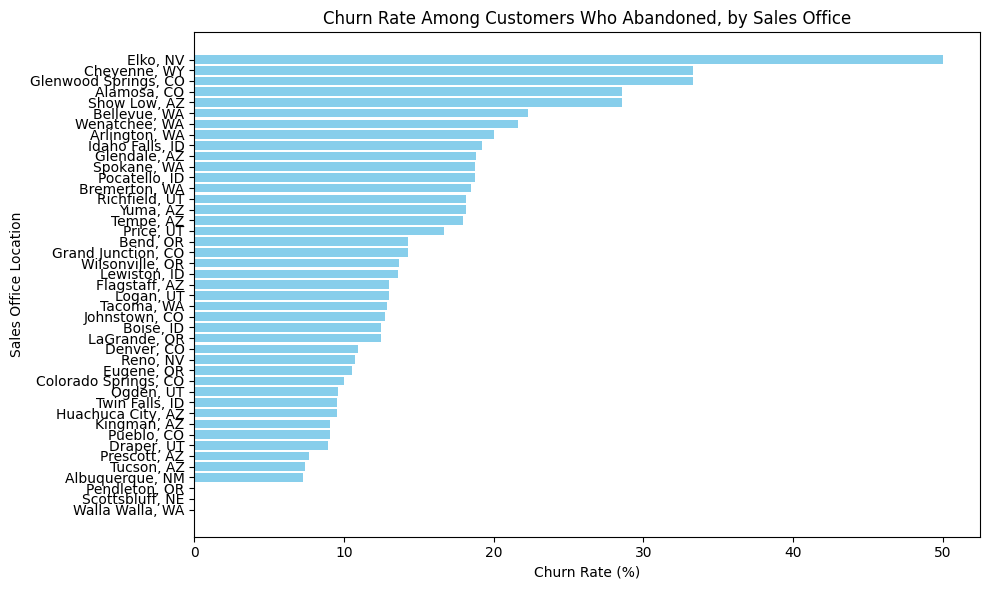

In [0]:
churn_summary = (
    combined_with_customer
    .groupby('sales_office_location')
    .agg(
        total_customers_who_abandoned=('customer_id', lambda x: x.nunique()),
        churned_customers=('customer_id', lambda x: x[combined_with_customer.loc[x.index, 'churned']].nunique())
    )
    .reset_index()
)

churn_summary['churn_rate'] = (
    churn_summary['churned_customers'] / churn_summary['total_customers_who_abandoned']
) * 100

# Sort by churn_rate descending
churn_summary_sorted = churn_summary.sort_values('churn_rate', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(
    churn_summary_sorted['sales_office_location'], 
    churn_summary_sorted['churn_rate'], 
    color='skyblue'
)
plt.xlabel('Churn Rate (%)')
plt.ylabel('Sales Office Location')
plt.title('Churn Rate Among Customers Who Abandoned, by Sales Office')
plt.gca().invert_yaxis()  # highest churn at the top
plt.tight_layout()
plt.show()

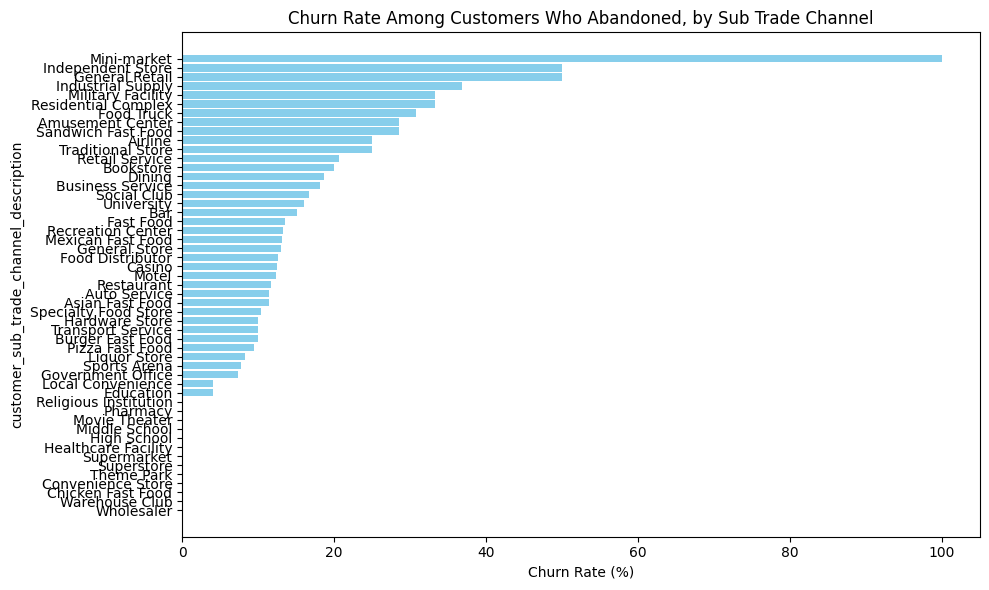

In [0]:
churn_summary = (
    combined_with_customer
    .groupby('customer_sub_trade_channel_description')
    .agg(
        total_customers_who_abandoned=('customer_id', lambda x: x.nunique()),
        churned_customers=('customer_id', lambda x: x[combined_with_customer.loc[x.index, 'churned']].nunique())
    )
    .reset_index()
)

churn_summary['churn_rate'] = (
    churn_summary['churned_customers'] / churn_summary['total_customers_who_abandoned']
) * 100

# Sort by churn_rate descending
churn_summary_sorted = churn_summary.sort_values('churn_rate', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(
    churn_summary_sorted['customer_sub_trade_channel_description'], 
    churn_summary_sorted['churn_rate'], 
    color='skyblue'
)
plt.xlabel('Churn Rate (%)')
plt.ylabel('customer_sub_trade_channel_description')
plt.title('Churn Rate Among Customers Who Abandoned, by Sub Trade Channel')
plt.gca().invert_yaxis()  # highest churn at the top
plt.tight_layout()
plt.show()

## Who Never Ordered Through MyCoke360 Again?

In [0]:
# Keep events after first abandon
after_abandon = combined_with_customer[
    combined_with_customer['event_date'] >= combined_with_customer['first_abandon_date']
]

# Aggregate per customer
customer_flags = after_abandon.groupby('customer_id').agg(
    ordered_any=('is_order', 'any'),
    purchased_any=('is_purchase', 'any'),
    abandoned_any=('is_abandon', 'any')
).reset_index()

# Filter: ordered but never purchased or abandoned again
ordered_only_customers = customer_flags[
    (customer_flags['ordered_any'] == True) &
    (customer_flags['purchased_any'] == False)
]

print(f"Customers who ordered but never purchased or abandoned again: {len(ordered_only_customers)}")
ordered_only_customers.head()

Customers who ordered but never purchased or abandoned again: 265


,customer_id,ordered_any,purchased_any,abandoned_any
4,500245840,True,False,True
5,500245848,True,False,True
9,500264136,True,False,True
16,500267669,True,False,True
22,500278923,True,False,True


In [0]:
# # Filter only orders after first abandon for the target customers
# orders_after_abandon = combined_with_customer[
#     (combined_with_customer['customer_id'].isin(ordered_only_customers['customer_id'])) &
#     (combined_with_customer['is_order'] == True) &
#     (combined_with_customer['event_date'] >= combined_with_customer['first_abandon_date'])
# ]

# # Count distinct order types
# order_type_counts = (
#     orders_after_abandon['order_type']
#     .value_counts(dropna=False)
#     .reset_index()
#     .rename(columns={'index': 'order_type', 'order_type': 'count'})
# )

# print("Order types used by customers who ordered but never purchased or abandoned again (after first abandon, excluding mycoke360):")
# print(order_type_counts)

In [0]:

# Separate events that occur before vs. after the first abandonment date
before_abandon = combined_with_customer[
    combined_with_customer['event_date'] < combined_with_customer['first_abandon_date']
]

after_abandon = combined_with_customer[
    combined_with_customer['event_date'] >= combined_with_customer['first_abandon_date']
]

# Get each customer’s unique order types before and after abandonment
before_types = (
    before_abandon[before_abandon['is_order']]
    .groupby('customer_id')['order_type']
    .unique()
    .reset_index()
    .rename(columns={'order_type': 'before_order_types'})
)

after_types = (
    after_abandon[after_abandon['is_order']]
    .groupby('customer_id')['order_type']
    .unique()
    .reset_index()
    .rename(columns={'order_type': 'after_order_types'})
)

# Merge the two
channel_switch = before_types.merge(after_types, on='customer_id', how='inner')

# flag customers who switched order_type
def switched(row):
    # If any order_type appears after that wasn't in the before set
    return not set(row['after_order_types']).issubset(set(row['before_order_types']))

channel_switch['switched_channel'] = channel_switch.apply(switched, axis=1)

# Separate switchers vs. non-switchers
switched_customers = channel_switch[channel_switch['switched_channel']]
print(f"Customers who switched order channel after first abandonment: {len(switched_customers)}")

# Optional — show a few examples
switched_customers.head(10)

Customers who switched order channel after first abandonment: 600


,customer_id,before_order_types,after_order_types,switched_channel
7,500264222,[sales_rep],"[sales_rep, mycoke360]",True
8,500265176,[mycoke_legacy],"[mycoke360, call_center]",True
14,500270307,[call_center],[mycoke360],True
15,500270906,"[sales_rep, call_center]",[mycoke360],True
18,500278923,[mycoke_legacy],[call_center],True
19,500282158,"[mycoke_legacy, mycoke360]","[mycoke360, call_center]",True
22,500285578,"[call_center, sales_rep]",[mycoke360],True
25,500291412,"[mycoke_legacy, mycoke360]","[mycoke360, call_center, sales_rep]",True
26,500291978,[call_center],[mycoke360],True
28,500296865,"[sales_rep, call_center, other]","[mycoke360, sales_rep, other]",True


In [0]:
from itertools import product

# Work only with customers who switched
switch_pairs = []

for _, row in switched_customers.iterrows():
    before = set(row['before_order_types'])
    after = set(row['after_order_types'])
    
    # Only capture new order types that appeared after abandonment
    new_channels = after - before

    # For each new channel, record all previous ones they used
    for b, a in product(before, new_channels):
        switch_pairs.append((b, a))

# Convert to DataFrame
switch_df = pd.DataFrame(switch_pairs, columns=['from_channel', 'to_channel'])

# Count most common switches
switch_summary = (
    switch_df.value_counts()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

print("Most common channel switches after abandonment:")
print(switch_summary.head(10))

Most common channel switches after abandonment:
    from_channel   to_channel  count
0      sales_rep    mycoke360    278
1    call_center    mycoke360    149
2  mycoke_legacy    mycoke360    147
3  mycoke_legacy  call_center     68
4  mycoke_legacy    sales_rep     60
5      mycoke360    sales_rep     59
6      mycoke360  call_center     58
7      sales_rep  call_center     51
8    call_center    sales_rep     28
9          other    mycoke360     27


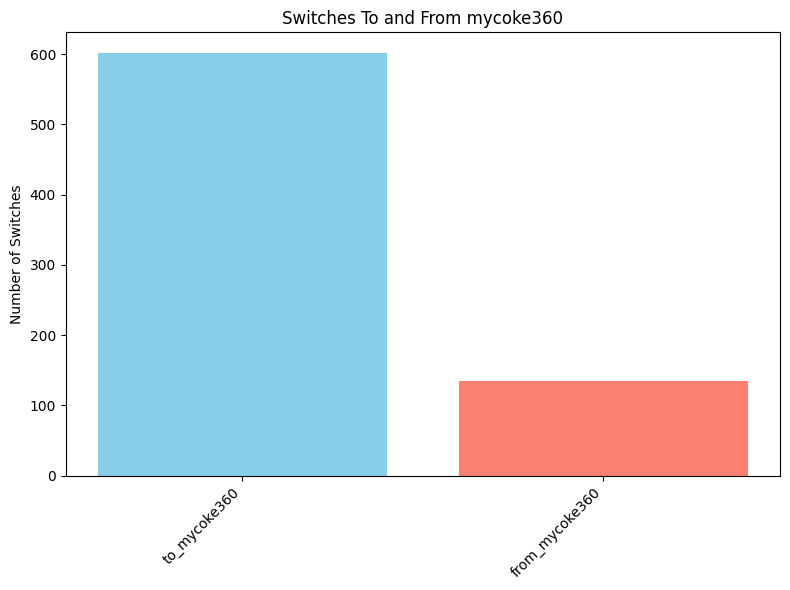

In [0]:
# Filter switches TO mycoke360
to_mycoke360 = switch_df[switch_df['to_channel'] == 'mycoke360']['to_channel'].value_counts().reset_index()
to_mycoke360.columns = ['channel', 'count']
to_mycoke360['direction'] = 'to_mycoke360'

# Filter switches FROM mycoke360
from_mycoke360 = switch_df[switch_df['from_channel'] == 'mycoke360']['from_channel'].value_counts().reset_index()
from_mycoke360.columns = ['channel', 'count']
from_mycoke360['direction'] = 'from_mycoke360'

# Combine
switch_plot_df = pd.concat([to_mycoke360, from_mycoke360], ignore_index=True)

# Plot
plt.figure(figsize=(8,6))
plt.bar(switch_plot_df['direction'], switch_plot_df['count'], color=['skyblue', 'salmon'])
plt.ylabel('Number of Switches')
plt.xticks(rotation=45, ha='right')
plt.title('Switches To and From mycoke360')
plt.tight_layout()
plt.show()